# Multi-Class SVM

This exercise guides you through the process of classifying images using Support Vector Machines(SVM). As part of this you will:

- Implement a fully vectorized loss function and for the SVM
- Calculate the analytical gradient using vectorized code
- Perform Stochastic Gradient Descent (SGD) to minimize the loss function
- Validate to tune the hyper-parameters
- Visualize the learned weights

In [1]:
# start-up code to import data-sets
from f16RBE595.get_cifar10 import load_CIFAR10
# loading some necessary packages
import numpy as np
import random
import matplotlib.pyplot as plt

# This is to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some code so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import sys

import matplotlib as mp

print('Python version ' + sys.version)
print('Matplot version ' + mp.__version__)
print('np version ' + np.version.version)

Python version 3.7.4 (default, Sep  5 2019, 06:39:29) 
[GCC 5.5.0 20171010]
Matplot version 3.1.1
np version 1.17.1


## Loading and Pre-processing CIFAR-10

Before proceeding, go to `WPI-F16-RBE595-HW1/f16RBE595/data/` and run the script `.get_datasets.sh` to download the CIFAR-10 data. 

In [3]:
# Assuming you have downloaded the CIFAR-10 database in your WPI-F16-RBE595-HW1/f16RBE595/data folder, 
# we proceed to load the data into python
#cifar10_dir = 'f16RBE595/data/cifar-10-batches-py'
cifar10_dir = '/home/nvidia/Downloads/f16RBE595/data/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print ('Training data shape: ', X_train.shape)
print ('Training labels shape: ', y_train.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


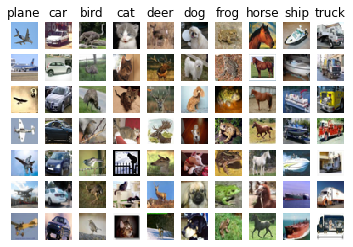

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Subsample the data for more efficient code execution in this exercise.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_training points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)
print ('Dev data shape: ', X_dev.shape)
print ('Dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)
Dev data shape:  (500, 32, 32, 3)
Dev labels shape:  (500,)


In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print ('Training data shape: ', X_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Test data shape: ', X_test.shape)
print ('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


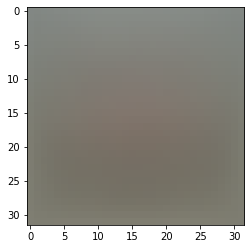

In [7]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print (mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image

In [8]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [9]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
# Also, lets transform both data matrices so that each image is a column.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])#.T
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])#.T
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])#.T
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
# print X_train[0][-1]
print (X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier
Code for this section will all be written inside `f16RBE595/classifiers/linear_svm.py`.

In [10]:
from f16RBE595.classifiers.linear_svm import svm_loss_vectorized
import time

# generate a random SVM weight matrix of small numbers
#W = np.random.randn(10,3073) * 0.0001 

W = np.random.randn(3073, 10) * 0.0001 

# Implement a vectorized code to implement the loss and the gradient of the SVM. 
# Remember that your code should not have any loops. 
# Hint: 
# Look up the broadcasting property of np arrays
# In case you have memory errors, you might want to use float16 or pickle your data
# check np.ndarray.dump()/load() if you consider pickling your data
tic = time.time()
loss, grad = svm_loss_vectorized(W, X_train, y_train, 0.00001)
#loss, grad = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print ('Vectorized loss and gradient: computed in %fs' % (toc - tic))
# It should be quite fast and finish within a second if your code is optimized! 

# check 
print ('loss is: ', loss)
# if your implementation is correct, loss should be around 9.0. 

# gradient check - The relative error between the numerical gradient and 
# your analytical gradient must be small 
from f16RBE595.gradient_check import grad_check_sparse
f = lambda w: svm_loss_vectorized(w, X_dev, y_dev, 0.0)[0]
grad_check_sparse(f, W, grad, 10)

Vectorized loss and gradient: computed in 2.844005s
loss is:  8.96564906390317
numerical: 10.273281 analytic: 13.406033, relative error: 1.322991e-01
numerical: 36.106409 analytic: 20.115336, relative error: 2.844286e-01
numerical: -1.481063 analytic: -3.014274, relative error: 3.410670e-01
numerical: 3.434817 analytic: 8.474583, relative error: 4.231755e-01
numerical: 9.557455 analytic: -3.262442, relative error: 1.000000e+00
numerical: 23.624579 analytic: 31.300560, relative error: 1.397535e-01
numerical: 0.498356 analytic: 4.824121, relative error: 8.127355e-01
numerical: 0.730436 analytic: -0.784156, relative error: 1.000000e+00
numerical: -4.781525 analytic: -6.989908, relative error: 1.876053e-01
numerical: -6.591435 analytic: -0.325353, relative error: 9.059236e-01


## Stochastic Gradient Descent (SGD)
Code for this section will be written in `f16RBE595/classifiers/linear_classifier.py`

In [11]:
# Now that we have efficient implementations for computing loss and gradients, let us use SGD to minimize 
# loss funtion

In [12]:
# Now implement SGD in LinearSVM.train() function and run it with the code below
from f16RBE595.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print ('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 787.414115
iteration 100 / 1500: loss 286.784426
iteration 200 / 1500: loss 107.609309
iteration 300 / 1500: loss 42.405587
iteration 400 / 1500: loss 18.600745
iteration 500 / 1500: loss 10.303333
iteration 600 / 1500: loss 6.571865
iteration 700 / 1500: loss 5.866972
iteration 800 / 1500: loss 5.899243
iteration 900 / 1500: loss 5.508083
iteration 1000 / 1500: loss 5.032229
iteration 1100 / 1500: loss 5.065343
iteration 1200 / 1500: loss 5.349784
iteration 1300 / 1500: loss 4.612365
iteration 1400 / 1500: loss 5.335572
That took 24.476245s


Text(0, 0.5, 'Loss value')

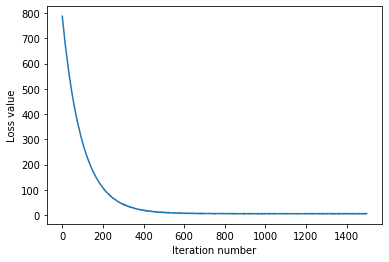

In [13]:
# A useful debugging strategy is to plot the training loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')

In [14]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print ('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print ('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.364122
validation accuracy: 0.367000


In [15]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 1e-6]
regularization_strengths = [2e4, 2.5e4, 3e4, 3.5e4, 4e4, 4.5e4, 5e4, 6e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
# Obtain all possible combinations
grid_search = [ (lr,rg) for lr in learning_rates for rg in regularization_strengths ]

for lr, rg in grid_search:
    # Create a new SVM instance
    svm = LinearSVM()
    # Train the model with current parameters
    train_loss = svm.train(X_train, y_train, learning_rate=lr, reg=rg,
                      num_iters=1500, verbose=False)
    # Predict values for training set
    y_train_pred = svm.predict(X_train)
    # Calculate accuracy
    train_accuracy = np.mean(y_train_pred == y_train)
    # Predict values for validation set
    y_val_pred = svm.predict(X_val)
    # Calculate accuracy
    val_accuracy = np.mean(y_val_pred == y_val)
    # Save results
    results[(lr,rg)] = (train_accuracy, val_accuracy)
    if best_val < val_accuracy:
        best_val = val_accuracy
        best_svm = svm

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 2.000000e+04 train accuracy: 0.373286 val accuracy: 0.400000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.360327 val accuracy: 0.367000
lr 1.000000e-07 reg 3.000000e+04 train accuracy: 0.366735 val accuracy: 0.365000
lr 1.000000e-07 reg 3.500000e+04 train accuracy: 0.363857 val accuracy: 0.376000
lr 1.000000e-07 reg 4.000000e+04 train accuracy: 0.363143 val accuracy: 0.368000
lr 1.000000e-07 reg 4.500000e+04 train accuracy: 0.355429 val accuracy: 0.361000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.352306 val accuracy: 0.365000
lr 1.000000e-07 reg 6.000000e+04 train accuracy: 0.354184 val accuracy: 0.378000
lr 1.000000e-06 reg 2.000000e+04 train accuracy: 0.265469 val accuracy: 0.293000
lr 1.000000e-06 reg 2.500000e+04 train accuracy: 0.286510 val accuracy: 0.287000
lr 1.000000e-06 reg 3.000000e+04 train accuracy: 0.280653 val accuracy: 0.283000
lr 1.000000e-06 reg 3.500000e+04 train accuracy: 0.298408 val accuracy: 0.311000
lr 1.000000e-06 reg 4.000000

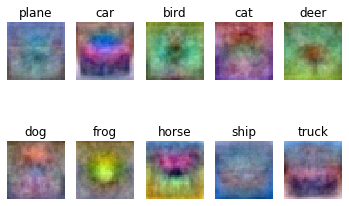

In [16]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])